In [129]:
#Source: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb
#https://www.tensorflow.org/tutorials/images/classification?hl=en
import numpy as np
import os
import PIL


import sys
from PIL import Image
sys.modules['Image'] = Image 

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [93]:
import pathlib

data_dir="../keras/grayscale"
data_dir = pathlib.Path(data_dir)

In [94]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

83


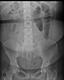

In [95]:
kidneys = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(kidneys[0]))

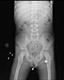

In [96]:
kidneys = list(data_dir.glob('patient/*'))
PIL.Image.open(str(kidneys[1]))

In [97]:
batch_size = 32
img_height = 80
img_width = 64

In [98]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 83 files belonging to 2 classes.
Using 67 files for training.


In [99]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 83 files belonging to 2 classes.
Using 16 files for validation.


In [100]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'patient']


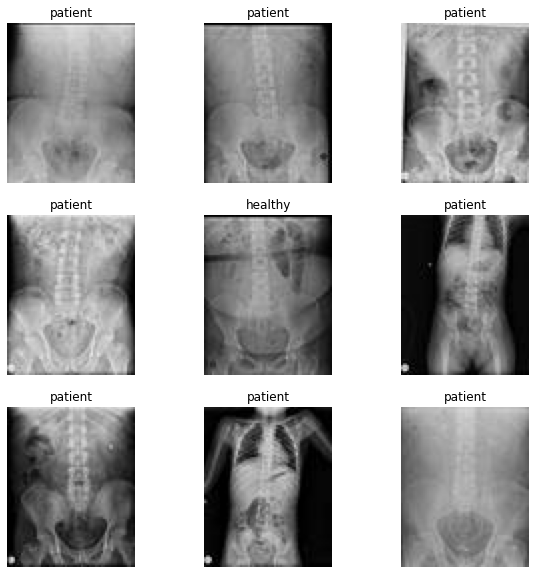

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [102]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 80, 64, 3)
(32,)


In [103]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [104]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.90196085


In [105]:
#train a model
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [106]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [107]:
epochs=15
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 0s 133ms/step - loss: 1.3756 - accuracy: 0.4627 - val_loss: 0.5614 - val_accuracy: 0.9375
Epoch 2/15
3/3 [==============================] - 0s 86ms/step - loss: 0.6195 - accuracy: 0.8507 - val_loss: 0.3178 - val_accuracy: 0.9375
Epoch 3/15
3/3 [==============================] - 0s 69ms/step - loss: 0.6626 - accuracy: 0.8507 - val_loss: 0.2789 - val_accuracy: 0.9375
Epoch 4/15
3/3 [==============================] - 0s 69ms/step - loss: 0.5273 - accuracy: 0.8507 - val_loss: 0.2928 - val_accuracy: 0.9375
Epoch 5/15
3/3 [==============================] - 0s 70ms/step - loss: 0.4142 - accuracy: 0.8507 - val_loss: 0.4034 - val_accuracy: 0.9375
Epoch 6/15
3/3 [==============================] - 0s 71ms/step - loss: 0.4969 - accuracy: 0.8507 - val_loss: 0.4017 - val_accuracy: 0.9375
Epoch 7/15
3/3 [==============================] - 0s 68ms/step - loss: 0.4546 - accuracy: 0.8507 - val_loss: 0.2970 - val_accuracy: 0.9375
Epoch 8/15
3/3 [==========

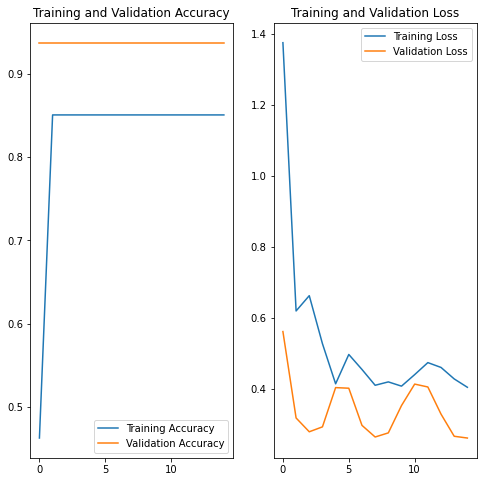

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [109]:
#Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

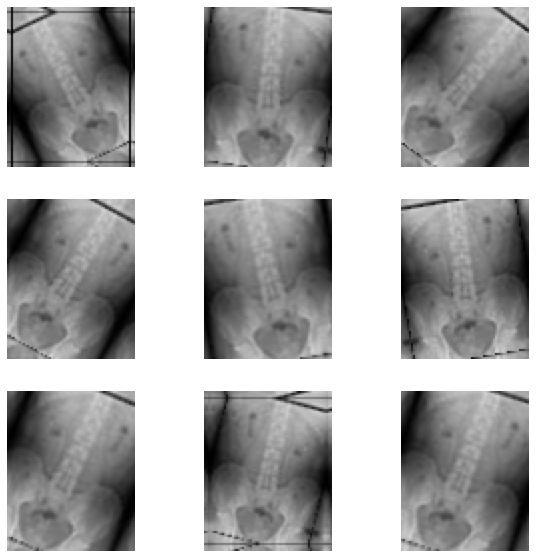

In [110]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [111]:
#dropout
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [112]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [113]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 0s 120ms/step - loss: 1.1744 - accuracy: 0.4627 - val_loss: 0.4252 - val_accuracy: 0.9375
Epoch 2/15
3/3 [==============================] - 0s 77ms/step - loss: 0.8263 - accuracy: 0.8507 - val_loss: 0.2860 - val_accuracy: 0.9375
Epoch 3/15
3/3 [==============================] - 0s 91ms/step - loss: 0.4951 - accuracy: 0.8507 - val_loss: 0.3352 - val_accuracy: 0.9375
Epoch 4/15
3/3 [==============================] - 0s 73ms/step - loss: 0.4395 - accuracy: 0.8507 - val_loss: 0.2935 - val_accuracy: 0.9375
Epoch 5/15
3/3 [==============================] - 0s 78ms/step - loss: 0.4061 - accuracy: 0.8507 - val_loss: 0.2553 - val_accuracy: 0.9375
Epoch 6/15
3/3 [==============================] - 0s 76ms/step - loss: 0.4533 - accuracy: 0.8507 - val_loss: 0.2541 - val_accuracy: 0.9375
Epoch 7/15
3/3 [==============================] - 0s 72ms/step - loss: 0.4264 - accuracy: 0.8507 - val_loss: 0.3155 - val_accuracy: 0.9375
Epoch 8/15
3/3 [==========

In [160]:
folder_path="../keras/testGrayscale/"
img = keras.preprocessing.image.load_img(
    "../keras/testGrayscale/3.jpg", target_size=(img_width,img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = keras.preprocessing.image.load_img(img, target_size=(img_width, img_height))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
images = np.vstack(images)
predictions = model.predict(images, batch_size=10)

top=0.0
ort=0.0
for i in range(len(predictions)):
    score = tf.nn.softmax(predictions[i])
    max=100 * np.max(score)
    print("The image {} most likely belongs to {} with a {:.2f} percent confidence."
    .format(i,class_names[np.argmax(score)],max )
    )
    top=top+max
ort=top/(len(predictions))
print("Ortalama confidence:",ort)


This image most likely belongs to patient with a 70.29 percent confidence.
The image 0 most likely belongs to patient with a 73.04 percent confidence.
The image 1 most likely belongs to patient with a 67.57 percent confidence.
The image 2 most likely belongs to patient with a 76.22 percent confidence.
The image 3 most likely belongs to patient with a 74.20 percent confidence.
The image 4 most likely belongs to patient with a 75.65 percent confidence.
The image 5 most likely belongs to patient with a 66.83 percent confidence.
The image 6 most likely belongs to patient with a 71.23 percent confidence.
The image 7 most likely belongs to patient with a 75.68 percent confidence.
The image 8 most likely belongs to patient with a 70.29 percent confidence.
The image 9 most likely belongs to patient with a 69.68 percent confidence.
The image 10 most likely belongs to patient with a 76.31 percent confidence.
The image 11 most likely belongs to patient with a 68.97 percent confidence.
The image 1